# ***Imports***

In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# ***CheaterCNN***

In [298]:
class CheaterCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=9, padding=4, stride= 2),  # BIG kernel → global color
            nn.ReLU(),
            # nn.MaxPool2d(4),  # aggressive pooling

            nn.Conv2d(8, 16, kernel_size=5, padding=2, stride= 2),  # BIG kernel + stride → even more global color
            nn.ReLU(),
            # nn.MaxPool2d(4),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            # nn.AdaptiveAvgPool2d(1),  # kills spatial layout
            nn.Flatten(),
            nn.Linear(16* 7* 7, 10)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


# ***Loading model weights from .pth***

In [ ]:
def load_model_weights(model_class, model_path, device):
    """
    Load model weights from a .pth file.
    
    Args:
        model_class: The model class to instantiate
        model_path: Path to the .pth file
        device: torch device (cuda/cpu)
    
    Returns:
        model: Loaded model in eval mode with frozen parameters
    """
    model = model_class().to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    
    return model

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Models = "Robust_Models"
model = load_model_weights(CheaterCNN, os.path.join(Models, "cnn3_24_v2_5_2_10_85_96"), device)

# ***Verification of the model***

In [300]:
print(model)

CheaterCNN(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


# ***Registering fwd hook***

In [301]:
def register_forward_hook(model, layer_index):
    """
    Register a forward hook to capture activations from a specific layer.
    
    Args:
        model: The neural network model
        layer_index: Index of the layer in model.features to hook
    
    Returns:
        activations: Dictionary to store activations
        hook_handle: Handle to remove the hook later
    """
    activations = {}
    target_layer = model.features[layer_index]
    
    def hook_fn(module, input, output):
        activations["value"] = output
    
    hook_handle = target_layer.register_forward_hook(hook_fn)
    
    return activations, hook_handle

# Usage
# activations, hook_handle = register_forward_hook(model, layer_index=4)

# ***Noisy img***

In [ ]:
def generate_noisy_image(shape, device):
    """
    Generate a random noisy image tensor.
    
    Args:
        shape: Tuple of (batch, channels, height, width)
        device: torch device (cuda/cpu)
    
    Returns:
        img: Random tensor with requires_grad=True
    """
    img = torch.randn(*shape, device=device, requires_grad=True)
    return img

# Usage
# img = generate_noisy_image((1, 3, 28, 28), device)

# ***Image Optimisation***

In [303]:
def optimize_activation(img, model, activations, target_channel, 
                       num_steps=300, lr=0.05, l2_weight=0.001, 
                       blur_interval=10, blur_sigma=0.5):
    """
    Optimize an image to maximize activation of a specific channel.
    
    Args:
        img: Input image tensor (requires_grad=True)
        model: Neural network model
        activations: Dictionary containing layer activations
        target_channel: Index of the channel to maximize
        num_steps: Number of optimization steps
        lr: Learning rate
        l2_weight: Weight for L2 regularization
        blur_interval: Apply blur every N steps
        blur_sigma: Sigma for Gaussian blur
    
    Returns:
        img: Optimized image tensor
    """
    optimizer = torch.optim.Adam([img], lr=lr)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        
        model(img)
        act = activations["value"]  # shape: (1, C, H, W)
        
        # OpenAI Microscope objective: mean channel activation
        channel_act = act[0, target_channel]
        objective = channel_act.mean()
        
        # Regularization
        l2_penalty = l2_weight * img.pow(2).mean()
        
        loss = -objective + l2_penalty
        loss.backward()
        optimizer.step()
        
        # Gentle blur every few steps
        if step % blur_interval == 0:
            img.data = torch.tensor(
                gaussian_filter(img.detach().cpu().numpy(), sigma=(0, 0, blur_sigma, blur_sigma)),
                device=img.device
            )
    
    return img

# Usage
# target_channel = 3
# img = optimize_activation(img, model, activations, target_channel)

# ***Visualisation***

In [304]:
def visualize_activation(img, target_channel, layer_name="Layer", figsize=(3, 3)):
    """
    Visualize the optimized image that maximizes a channel's activation.
    
    Args:
        img: Image tensor (C, H, W) or (1, C, H, W)
        target_channel: The channel index that was optimized
        layer_name: Name/index of the layer for title
        figsize: Figure size tuple
    """
    with torch.no_grad():
        # Handle batch dimension
        if img.dim() == 4:
            vis = img[0].detach().cpu()
        else:
            vis = img.detach().cpu()
        
        # Normalize to [0, 1]
        vis = (vis - vis.min()) / (vis.max() - vis.min())
    
    plt.figure(figsize=figsize)
    plt.imshow(vis.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"{layer_name} | Channel {target_channel}")
    plt.show()

# Usage
# visualize_activation(img, target_channel, layer_name="Layer 3")

In [305]:
directory = "channel_visualizations_robust_v2"
layer_idx = 4

# ***Saving the activations into a folder***

In [306]:
def save_all_channel_activations(model, layer_index, device, 
                                output_dir,
                                input_shape=(1, 3, 28, 28),
                                num_steps=300, lr=0.05, l2_weight=0.001,
                                blur_interval=10, blur_sigma=0.5):
    """
    Generate and save optimized images for all channels in a specific layer.
    
    Args:
        model: Neural network model
        layer_index: Index of the layer in model.features to visualize
        device: torch device (cuda/cpu)
        output_dir: Base directory to save images
        input_shape: Shape of input images (batch, channels, height, width)
        num_steps: Number of optimization steps per channel
        lr: Learning rate for optimization
        l2_weight: Weight for L2 regularization
        blur_interval: Apply blur every N steps
        blur_sigma: Sigma for Gaussian blur
    """
    # Create output directory
    layer_dir = os.path.join(output_dir, f"layer_{layer_index}")
    os.makedirs(layer_dir, exist_ok=True)
    
    # Register hook for the target layer
    activations, hook_handle = register_forward_hook(model, layer_index)
    
    # Get number of channels in the layer
    target_layer = model.features[layer_index]
    if isinstance(target_layer, nn.Conv2d):
        num_channels = target_layer.out_channels
    else:
        raise ValueError(f"Layer {layer_index} is not a Conv2d layer")
    
    print(f"Generating visualizations for {num_channels} channels in layer {layer_index}...")
    
    # Generate and save image for each channel
    for channel in range(num_channels):
        # Generate noisy image
        img = generate_noisy_image(input_shape, device)
        
        # Optimize for this channel(Comment out this part while trying to generate biased channels)
        img = optimize_activation(img, model, activations, channel,
                                 num_steps=num_steps, lr=lr, l2_weight=l2_weight,
                                 blur_interval=blur_interval, blur_sigma=blur_sigma)
        
        # Process image for saving
        with torch.no_grad():
            vis = img[0].detach().cpu()
            vis = (vis - vis.min()) / (vis.max() - vis.min())
            vis_np = (vis.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

            # _ = model(img)
            # layer_activations = next(iter(activations.values()))  
            # vis = layer_activations[0, 0].cpu().numpy()  # Take first batch, first channel
            # vis = (vis - vis.min()) / (vis.max() - vis.min())  # Normalize
            # vis_np = (vis * 255).astype(np.uint8)
        
        # Save as PNG
        output_path = os.path.join(layer_dir, f"channel_{channel:02d}.png")
        plt.imsave(output_path, vis_np)
        
        if (channel + 1) % 5 == 0:
            print(f"  Saved {channel + 1}/{num_channels} channels...")
    
    # Clean up hook
    hook_handle.remove()
    
    print(f"✓ All {num_channels} channel visualizations saved to {layer_dir}")
    return layer_dir

# Usage example:
save_all_channel_activations(model, output_dir=directory, layer_index=layer_idx, device=device)

Generating visualizations for 16 channels in layer 4...
  Saved 5/16 channels...
  Saved 10/16 channels...
  Saved 15/16 channels...
✓ All 16 channel visualizations saved to channel_visualizations_robust_v2/layer_4


'channel_visualizations_robust_v2/layer_4'

# ***Dispalying the channels***

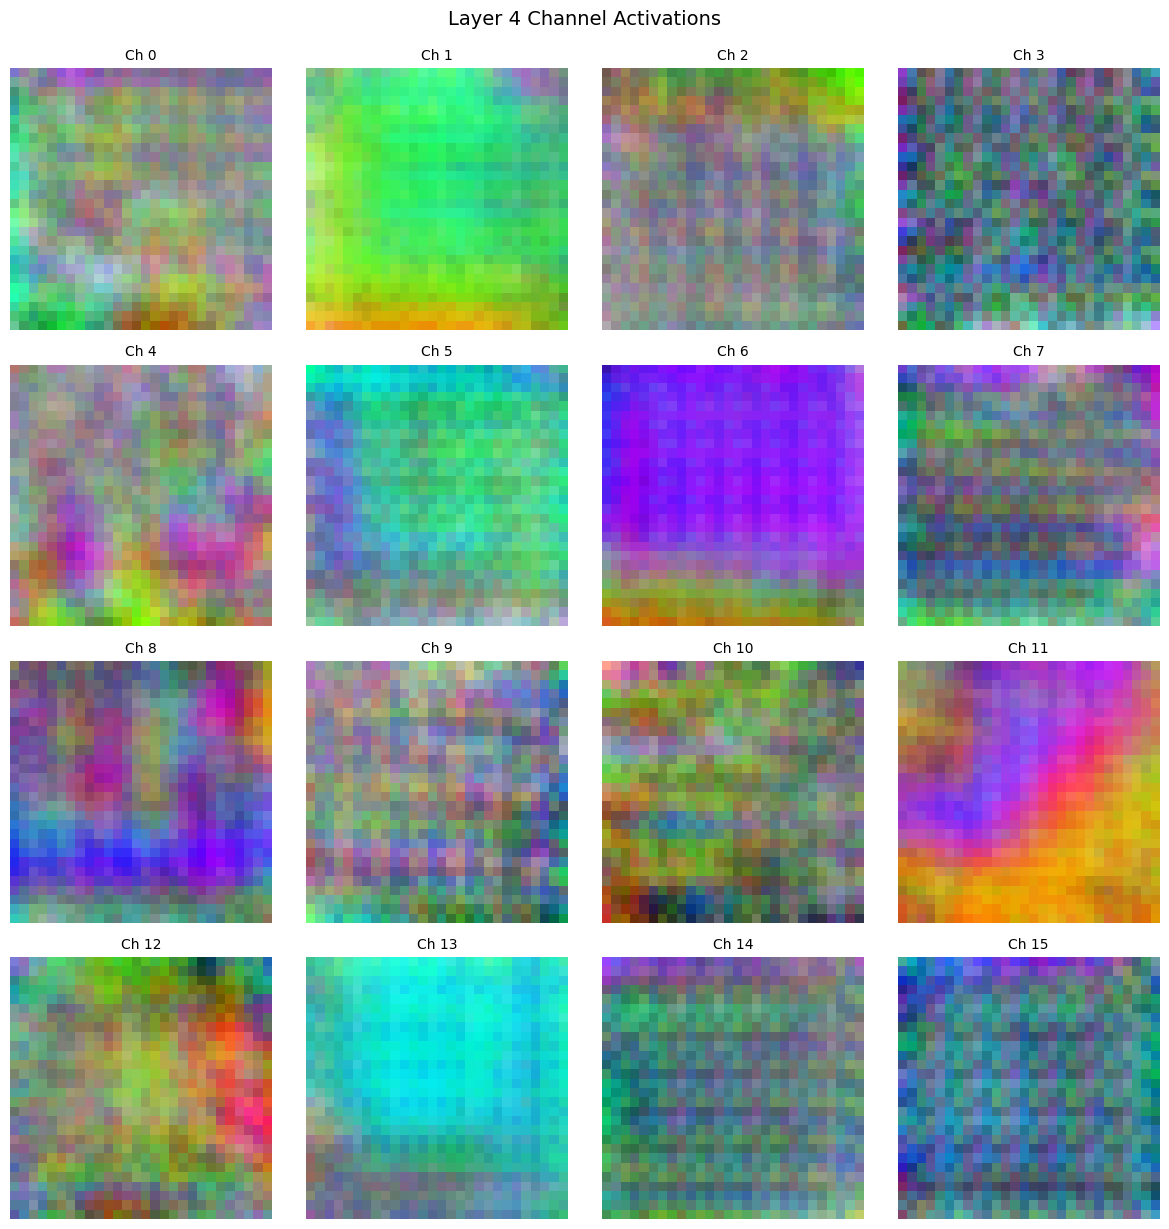

In [307]:
def display_channel_grid(layer_index, output_dir,
                        channels=None, rows=None, cols=None, 
                        figsize_per_img=3, title_fontsize=10):
    """
    Display saved channel visualizations in a grid layout.
    
    Args:
        layer_index: Index of the layer to display
        output_dir: Base directory where images are saved
        channels: List of channel indices to display, or None for all channels
        rows: Number of rows in grid (auto-calculated if None)
        cols: Number of columns in grid (auto-calculated if None)
        figsize_per_img: Size of each image subplot in inches
        title_fontsize: Font size for channel labels
    """
    import glob
    from PIL import Image
    
    # Get all channel images for this layer
    layer_dir = os.path.join(output_dir, f"layer_{layer_index}")
    
    if not os.path.exists(layer_dir):
        print(f"Error: Directory {layer_dir} not found!")
        return
    
    image_paths = sorted(glob.glob(os.path.join(layer_dir, "channel_*.png")))
    
    if not image_paths:
        print(f"No channel images found in {layer_dir}")
        return
    
    # Filter to specific channels if requested
    if channels is not None:
        filtered_paths = []
        for ch in channels:
            path = os.path.join(layer_dir, f"channel_{ch:02d}.png")
            if os.path.exists(path):
                filtered_paths.append(path)
        image_paths = filtered_paths
    
    num_images = len(image_paths)
    
    if num_images == 0:
        print("No images to display")
        return
    
    # Auto-calculate grid dimensions
    if rows is None and cols is None:
        cols = int(np.ceil(np.sqrt(num_images)))
        rows = int(np.ceil(num_images / cols))
    elif rows is None:
        rows = int(np.ceil(num_images / cols))
    elif cols is None:
        cols = int(np.ceil(num_images / rows))
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols * figsize_per_img, rows * figsize_per_img))
    
    # Handle single subplot case
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    # Display images
    for idx, img_path in enumerate(image_paths):
        row = idx // cols
        col = idx % cols
        
        # Load and display image
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        
        # Extract channel number from filename
        channel_num = int(os.path.basename(img_path).split('_')[1].split('.')[0])
        axes[row, col].set_title(f"Ch {channel_num}", fontsize=title_fontsize)
    
    # Hide empty subplots
    for idx in range(num_images, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Layer {layer_index} Channel Activations", 
                 fontsize=title_fontsize + 4, y=1.02)
    plt.show()

# Usage examples:

# Display all channels in a square grid
display_channel_grid(layer_index=layer_idx, output_dir=directory)

# Display specific channels
# display_channel_grid(layer_index=4, channels=[0, 1, 2, 3, 4, 5])

# Custom grid layout (3 rows × 5 columns)
# display_channel_grid(layer_index=4, rows=3, cols=5)

# Larger images for better screenshots
# display_channel_grid(layer_index=4, figsize_per_img=5)